In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import country_converter as coco
cc = coco.CountryConverter()

# Suppress future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
region_agg = coco.agg_conc(original_countries='EXIO3', aggregates=["EU"], missing_countries='Non EU', merge_multiple_string=None)
region_dict = region_agg.set_index('original')['aggregated'].to_dict()

file_path = "inputs/input_sectors_group.csv"
sectors_list = pd.read_csv(file_path)

sector_agg = sectors_list["sector"].to_frame(name="original")
sector_agg = sector_agg.merge(sectors_list, left_on="original", right_on="sector", how="outer")
sector_agg["aggregate_sector"] = sector_agg["classification"].fillna("Others") 
sector_agg = sector_agg[["original","aggregate_sector"]]

In [4]:
stage = "manufacturing"
file_path = "outputs/emission_product_country_ALL.csv"
emission = pd.read_csv(file_path)
emission = emission.merge(sector_agg, left_on="sector", right_on="original", how="outer").drop(columns="original")

emission["aggregate_product"] = emission["product"].map(region_dict)
emission["aggregate"] = emission["region"].map(region_dict)
emission["emission"] = emission["emission"] * 1000000 # from Gg to Kg 


country_dict = dict(zip(emission["region"].unique(), coco.convert(names=emission["region"].unique(), to='name_short')))
country_dict['WA'] = 'Rest of World Asia Pacific'
country_dict['WE'] = 'Rest of World Eropa'
country_dict['WL'] = 'Rest of World America'
country_dict['WM'] = 'Rest of World Middle East'

emission["product"] = emission["product"].map(country_dict)
emission["region"] = emission["region"].map(country_dict)

country_list = emission["product"].unique().tolist()

WA not found in ISO2
WL not found in ISO2
WE not found in ISO2
WM not found in ISO2
nan not found in ISO3


In [5]:
emission_all = emission.groupby(["vehicles","aggregate_product","product"]).sum("emission").reset_index()
emission_compare = pd.pivot_table(data=emission_all,index=["vehicles"],columns=["aggregate_product","product"],values="emission",aggfunc="sum")

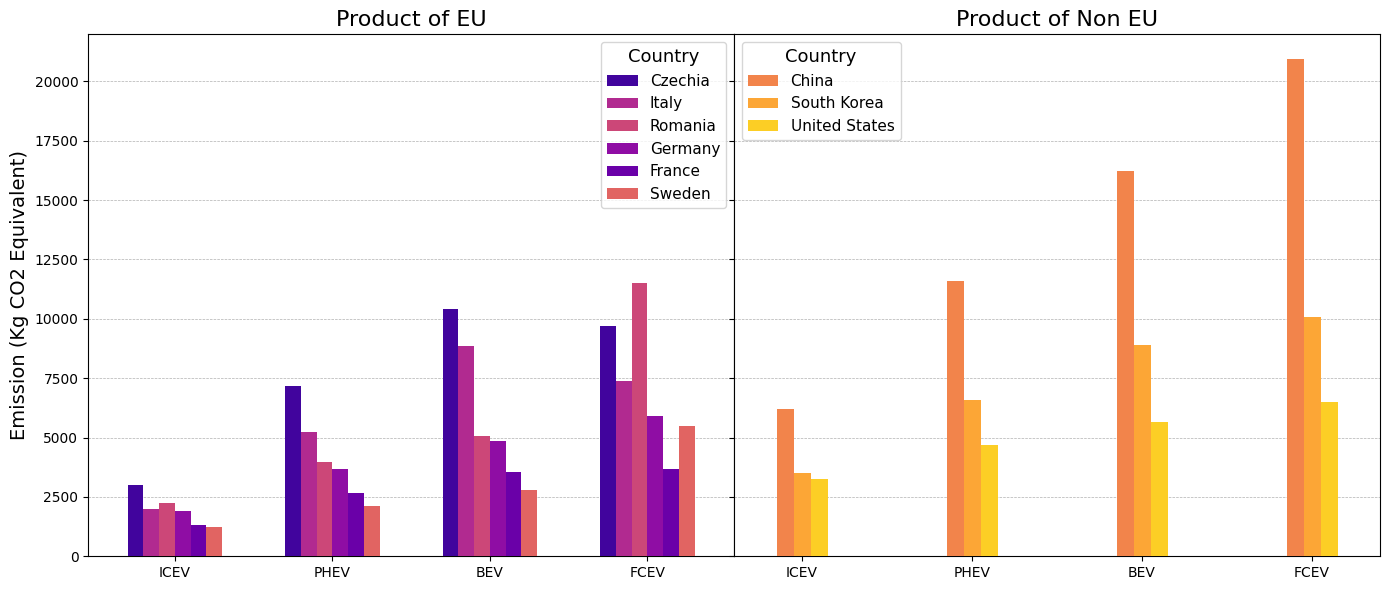

In [6]:
vehicles_order = ['ICEV', 'PHEV', 'BEV', 'FCEV']

df = emission_compare.reindex(vehicles_order)
fig_width = 14
fig_height = 6
agg_list = ["EU","Non EU"]

# Plotting

# Define a consistent colormap
countries = df.columns.get_level_values(1).unique()
colors = sns.color_palette("plasma", n_colors=len(countries))
color_mapping = {country: color for country, color in zip(countries, colors)}

fig,axes = plt.subplots(nrows=1,ncols=2,figsize=(fig_width, fig_height),sharey=True)
for ax,agg in zip(axes,agg_list):
    data = df[agg].T
    data.sort_values("BEV",ascending=False,inplace=True)
    data = data.T
    #print(data)
    
    # Calculate the number of bars for normalization
    bars = len(data.columns)
    bar_width = 0.1 * bars

    data.plot(kind='bar',width=bar_width,ax=ax,color=[color_mapping[col] for col in data.columns],zorder=3)

    # Customize each subplot
    ax.set_title(f'Product of {agg}', fontsize=16)
    ax.set_xlabel(None)
    ax.set_ylabel('Emission (Kg CO2 Equivalent)', fontsize=14)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha='center')
    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
    ax.legend(title='Country', title_fontsize='13', fontsize='11')

# Show the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig("charts/chart_footprint_manufacturing_per_vehicle_country.png", dpi=100)
plt.show()

In [7]:
top_sectors_number = 25

emission_agg = emission.groupby(["vehicles","aggregate_product","product","aggregate_sector","sector"]).sum("emission").reset_index()
emission_total = emission.groupby(["vehicles","aggregate_product","product"]).sum("emission").reset_index()

top_sectors = emission_agg.groupby('sector')['emission'].sum().reset_index().sort_values(by='emission', ascending=False).head(top_sectors_number)
emission_top = emission_agg[emission_agg.sector.isin(top_sectors["sector"].tolist())]

emission_pivot = pd.pivot_table(data=emission_top,index=["vehicles","aggregate_sector","sector"],columns=["aggregate_product","product"],values="emission",aggfunc="sum")

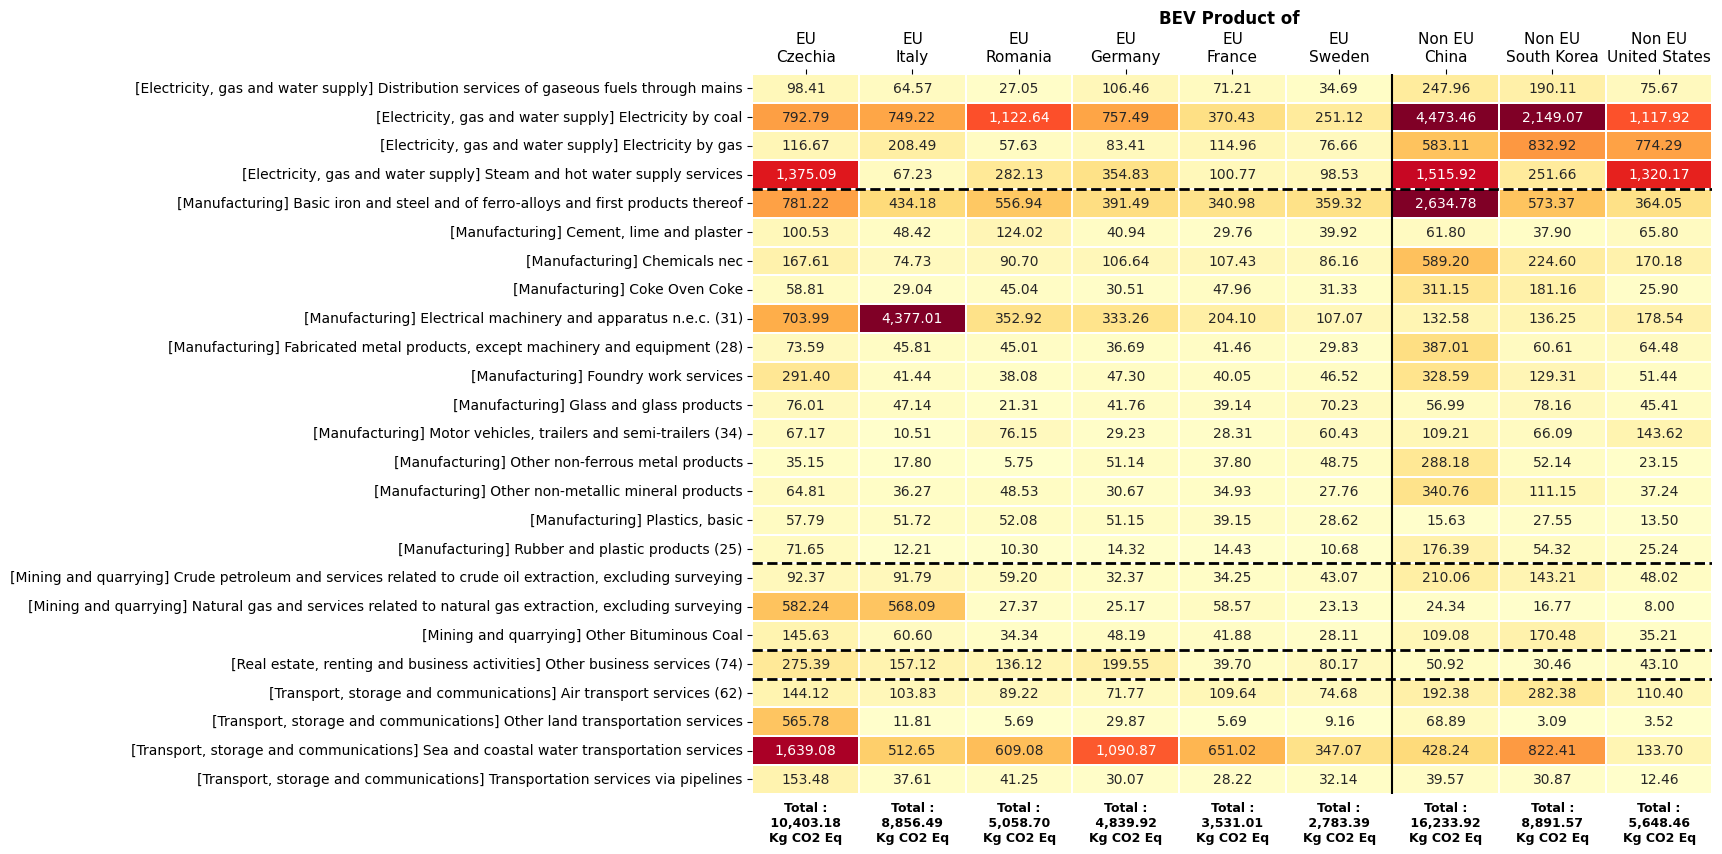

In [8]:


heatmap_width = 16
heatmap_height = 12
vmax_par = 1.8e3
cmap_par = 'YlOrRd'
fmt_par = ",.2f"
linewidths_par = 0.1
cbar_pad_par = 0.1

vehicle="BEV"
fig, ax = plt.subplots(figsize=(heatmap_width,heatmap_height), sharey=True)
data = emission_pivot.loc[vehicle]


# create sorting 
columns = {}
columns["EU"] = df["EU"].T.sort_values(vehicle,ascending=False).T.columns
columns["Non EU"] = df["Non EU"].T.sort_values(vehicle,ascending=False).T.columns

multi_index_tuples = [(key, value) for key, values in columns.items() for value in values]
multi_index = pd.MultiIndex.from_tuples(multi_index_tuples, names=['aggregate_product', 'product'])
data = data[multi_index]

#===================================================================================

heatmap = sns.heatmap(data, ax=ax, annot=True, cmap=cmap_par, 
                      vmax = vmax_par,linewidths=linewidths_par, fmt=fmt_par, 
                      cbar=False,cbar_kws={'label': 'kg CO2 Equivalent','pad': cbar_pad_par})
ax.set_ylabel(None)
ax.set_xlabel(None)
ax.xaxis.tick_top()

# reformat y labels
new_x_labels = [f'{level0}\n{level1}' for level0, level1 in data.columns]
ax.set_xticklabels(new_x_labels, rotation=0, fontsize=11)

new_y_labels = [f'[{level0}] {level1}' for level0, level1 in data.index]
ax.set_yticklabels(new_y_labels)

# Add total emission label
i=0
for region, country in data.columns.to_list():
    row = emission_total[(emission_total["vehicles"] == vehicle) & (emission_total["product"] == country)]
    total = row["emission"].values[0]
    ax.text(i + 0.5, heatmap_height*2 + 2, f"Total :\n {total:,.2f} \nKg CO2 Eq", ha='center', va='center', color='black', fontsize=9, fontweight="bold")
    i += 1

ax.axvline(x = len(data["EU"].columns), color="black",linestyle="solid")

separators = []
for i in range(1, len(data.index)):
    if data.index[i][0] != data.index[i - 1][0]:
        separators.append(i)
for sep in separators:
    ax.axhline(sep, color='black', linestyle='--', linewidth=2)

plt.title(f"{vehicle} Product of ", fontweight='bold',fontsize =12)
plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2,wspace=0.05)
plt.savefig('charts/heatmap_emission_country_product_BEV.png', dpi=100,  bbox_inches='tight')
plt.show()

In [4]:







# SPACER - Start Country Level Analysis based on Outlook

In [11]:
stage = "manufacturing"
demand = "normal"
file_path = "outputs/emission_by_stage_"+stage+"_"+demand+"_country.csv"
emission = pd.read_csv(file_path)
emission["emission"] = emission["emission"] * 0.001 # Gg to Mt 
emission = emission.merge(sector_agg, left_on="sector", right_on="original", how="outer").drop(columns="original")

emission["aggregate"] = emission["region"].map(region_dict)

country_dict = dict(zip(emission["region"].unique(), coco.convert(names=emission["region"].unique(), to='name_short')))
country_dict['WA'] = 'Rest of World Asia Pacific'
country_dict['WE'] = 'Rest of World Eropa'
country_dict['WL'] = 'Rest of World America'
country_dict['WM'] = 'Rest of World Middle East'

emission["region"] = emission["region"].map(country_dict)

WA not found in ISO2
WL not found in ISO2
WE not found in ISO2
WM not found in ISO2
nan not found in ISO3


In [12]:
emission_all = emission.groupby(["vehicles","aggregate","region"]).sum("emission").reset_index()
emission_pivot= pd.pivot_table(data=emission_all,index=["aggregate","region"],columns=["vehicles"],values="emission",aggfunc="sum")

emission_pivot.sort_values(by="BEV",ascending=False,inplace=True)
emission_pivot.drop(columns=["FCEV"])
emission_pivot = emission_pivot[["ICEV","PHEV","BEV"]] 

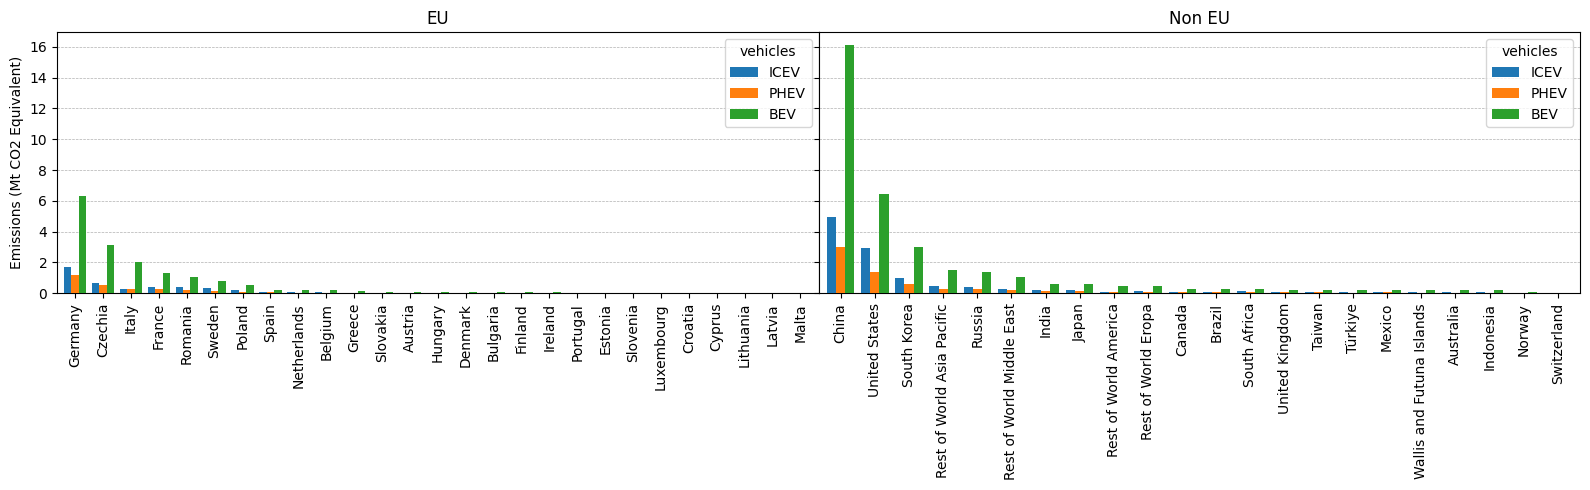

In [13]:
agg_list = ["EU","Non EU"]
fig_width = 16
fig_height = 5

fig,axes = plt.subplots(nrows=1,ncols=2,sharey=True)

for ax, agg in zip(axes,agg_list):
    data = emission_pivot.loc[agg] 
    data.plot(kind='bar',ax = ax,width=0.8,figsize=[fig_width,fig_height],zorder=3)
    ax.set_title(f"{agg}")
    ax.set_xlabel(None)
    ax.yaxis.grid(True, which='both', linestyle='--', linewidth=0.5, zorder=1)
    ax.set_ylabel("Emissions (Mt CO2 Equivalent)")

# Show the plot
plt.tight_layout()
plt.subplots_adjust(wspace=0)
plt.savefig("charts/chart_emission_manufacturing_per_vehicle_country_APS_2030.png", dpi=100)
plt.show()

In [44]:
#show in the world map chart
import geopandas as gpd

df = emission_pivot.reset_index()
cc = coco.CountryConverter()
df["ISO"] = df['region'].apply(lambda x: cc.convert(names=x, to='ISO3'))

# Load a world map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
gdf = world.merge(df, left_on='iso_a3', right_on='ISO',how="outer")

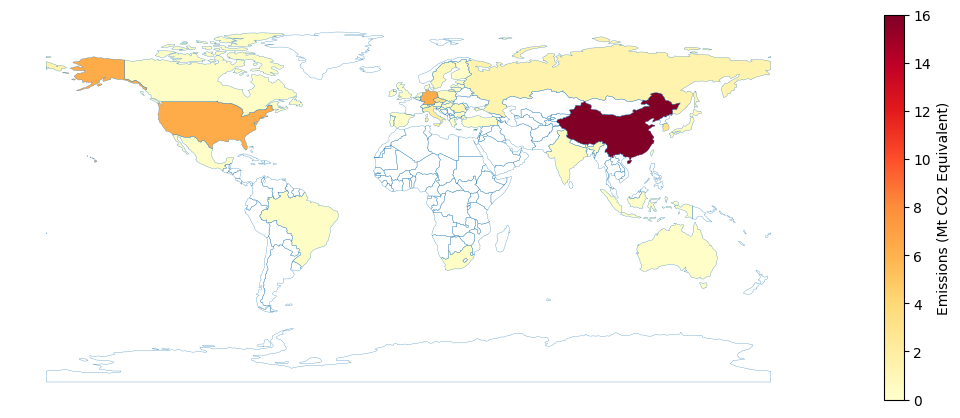

In [71]:
vmax_par = 16
cmap_par = "YlOrRd"

gdf = gpd.GeoDataFrame(gdf, geometry='geometry')
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
gdf.boundary.plot(ax=ax, linewidth=0.2)
gdf.plot(column='BEV', ax=ax, legend=True, vmin=0, vmax=vmax_par,cmap=cmap_par,
         legend_kwds={'label': "Emissions (Mt CO2 Equivalent)",
                      'orientation': "vertical"})

ax.set_axis_off()
plt.savefig('charts/heatmap_worldmap_emission_manufacturing_BEV_APS_2030_country_sector.png', dpi=100,  bbox_inches='tight')
plt.show()

In [14]:
top_countries_number = 50
top_sectors_number = 20

top_countries = emission.groupby('region')['emission'].sum().reset_index().sort_values(by='emission', ascending=False).head(top_countries_number)
emission_top = emission[emission.region.isin(top_countries["region"].tolist())]

top_sectors = emission.groupby('sector')['emission'].sum().reset_index().sort_values(by='emission', ascending=False).head(top_sectors_number)
emission_top = emission_top[emission_top.sector.isin(top_sectors["sector"].tolist())]

emission_pivot = pd.pivot_table(data=emission_top,index=["vehicles","aggregate_sector","sector"],columns=["aggregate","region"],values="emission",aggfunc="sum")


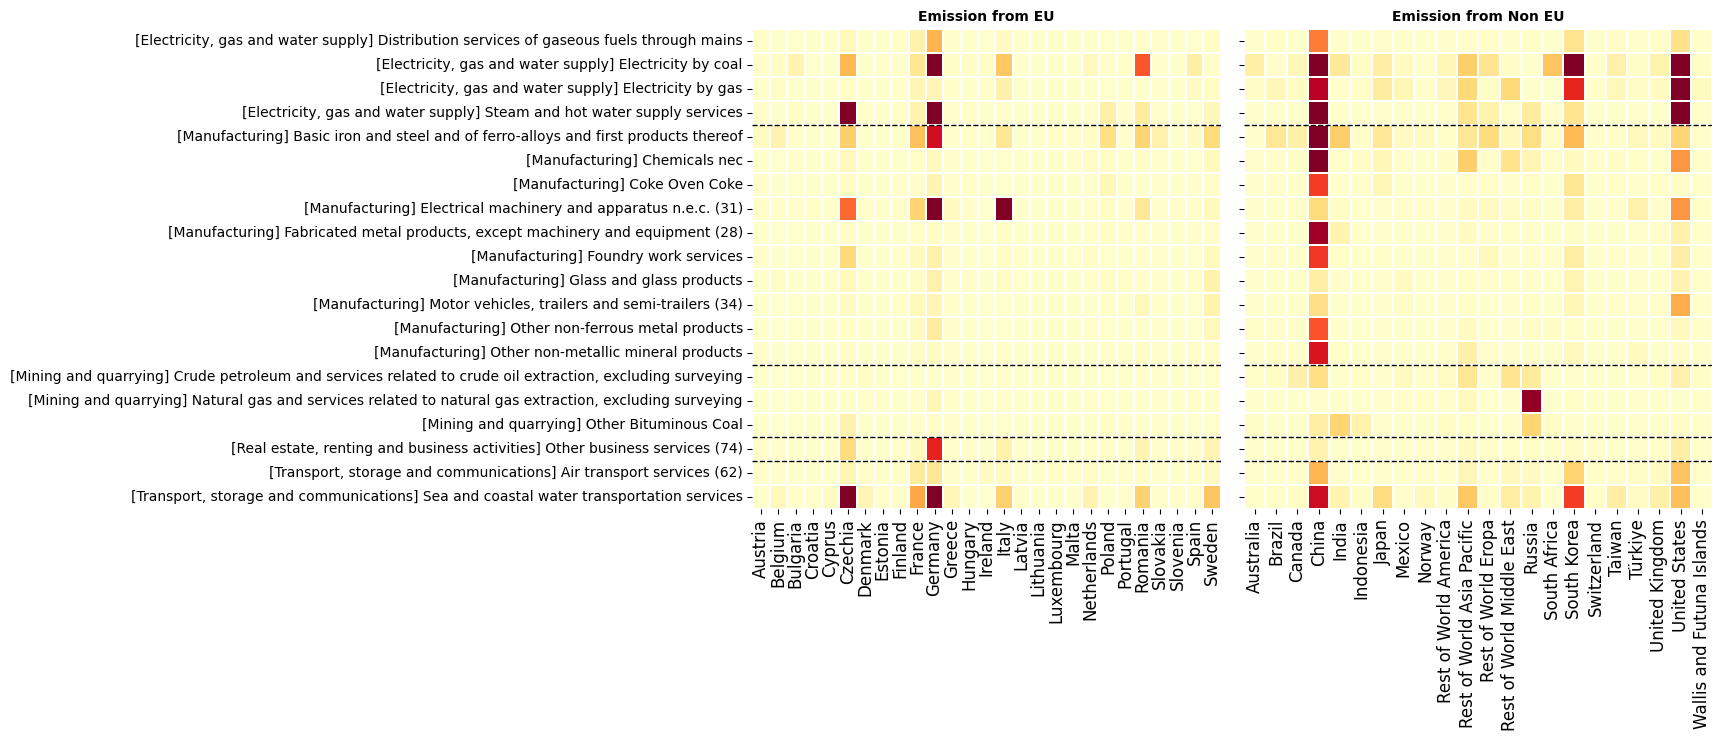

In [22]:
#======================
heatmap_width = 16
heatmap_height = 8
vmax_par = 0.5
cmap_par = 'YlOrRd'
fmt_par = ",.2f"
linewidths_par = 0.1
cbar_pad_par = 0.1
vehicle="BEV"
agg_list = ["EU","Non EU"]

fig, axes = plt.subplots(nrows=1,ncols=2,figsize=(heatmap_width,heatmap_height), sharey=True)

for ax,agg in zip(axes, agg_list):
    df = emission_pivot.loc[vehicle]
    heatmap = sns.heatmap(df[agg], vmax=vmax_par, ax=ax, annot=False, cmap=cmap_par, 
                         linewidths=linewidths_par, fmt=fmt_par, 
                          cbar=False,cbar_kws={'label': 'kg CO2 Equivalent','pad': cbar_pad_par})
    ax.set_title(f"Emission from {agg}",fontweight='bold',fontsize=10)
    ax.set_xlabel(None)
    ax.set_ylabel(None)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=12)

    separators = []
    for i in range(1, len(df.index)):
        if df.index[i][0] != df.index[i - 1][0]:
            separators.append(i)
    for sep in separators:
        ax.axhline(sep, color='black', linestyle='--', linewidth=1)

    # reformat y labels
    new_y_labels = [f'[{level0}] {level1}' for level0, level1 in df.index]
    ax.set_yticklabels(new_y_labels)
    #ax.set_yticklabels(ax.get_yticklabels(), fontsize=15)

plt.subplots_adjust(left=0.2, right=0.8, top=0.8, bottom=0.2,wspace=0.05)
plt.savefig('charts/heatmap_emission_manufacturing_BEV_APS_2030_country_sector.png', dpi=100,  bbox_inches='tight')
plt.show()

    